## Demo： Bayesian neural network via MCMC inference

In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

# local imports
from mfbml.problems import  mf_Forrester_torch
from mfbml.methods.bayes_neural_nets import BNNWrapper


# fix the random seed for reproducibility
seed = 1999
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:


class GammaNoise:

    def __init__(self, 
                 alpha: float =2.0,
                 beta : float= 1.0) -> None:
        

        # assert values of alpha and beta
        assert alpha>0, "alpha must be greater than 0"
        assert beta>0,  "beta must be greater than 0"

        self.alpha = alpha
        self.beta = beta

        # get the statistics of the Gamma distribution
        self.mean = alpha/beta
        self.variance = alpha/(beta**2)
        self.std = np.sqrt(self.variance)
        self.mode = (alpha - 1) / beta if alpha > 1 else 0

    def get_noise(self, samples: torch.Tensor) -> torch.Tensor:
        """
        Generate noise samples from the Gamma distribution
        """

        # Generate samples from the Gamma distribution
        gamma_dist = torch.distributions.Gamma(self.alpha, self.beta)
        gamma_samples = gamma_dist.sample(sample_shape=samples.shape)

        # Shift the distribution so the mode is at 0
        shifted_samples = gamma_samples - self.mode

        return shifted_samples
    
    def visualize(self, num_samples: int = 10000) -> None:
        """
        Visualize the Gamma distribution
        """

        # Generate samples from the Gamma distribution
        gamma_dist = torch.distributions.Gamma(self.alpha, self.beta)
        gamma_samples = gamma_dist.sample((num_samples,))

        # Shift the distribution so the mode is at 0
        shifted_samples = gamma_samples - self.mode

        # Plot the shifted Gamma distribution
        plt.hist(shifted_samples.numpy(),
                 bins=100, 
                 density=True, alpha=0.75, label='Mode-Shifted Gamma')

        # Add title and labels
        plt.title('Gamma Distribution Shifted by Mode')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()



In [3]:
# define Gaussian noise 

class GaussianNoise:

    def __init__(self,
                 mu: float = 0.0 ,
                 sigma: float = 0.5) -> None:
        
        # assert the value of sigma
        assert sigma>=0, "standard deviation should larger than 0"

        self.mu = mu 
        self.sigma = sigma 

        # get the statistis of the Gaussian distribution
        self.mean = mu
        self.variance = sigma**2
        self.std = sigma

    
    def get_noise(self, samples: torch.Tensor) -> torch.Tensor:
        """
        Generate noise samples from the Gaussian distribution
        """

        # Generate samples from the Gaussian distribution
        normal_dist = torch.distributions.Normal(self.mu, self.sigma)
        normal_samples = normal_dist.sample(sample_shape=samples.shape)

        return normal_samples
    
    def visualize(self, num_samples: int = 10000) -> None:
        """
        Visualize the Gaussian distribution
        """

        # Generate samples from the Gaussian distribution
        normal_dist = torch.distributions.Normal(self.mu, self.sigma)
        normal_samples = normal_dist.sample((num_samples,))

        # Plot the Gaussian distribution
        plt.hist(normal_samples.numpy(),
                 bins=100, 
                 density=True, alpha=0.75, label='Gaussian')

        # Add title and labels
        plt.title('Gaussian Distribution')
        plt.xlabel('Value')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True)
        plt.show()



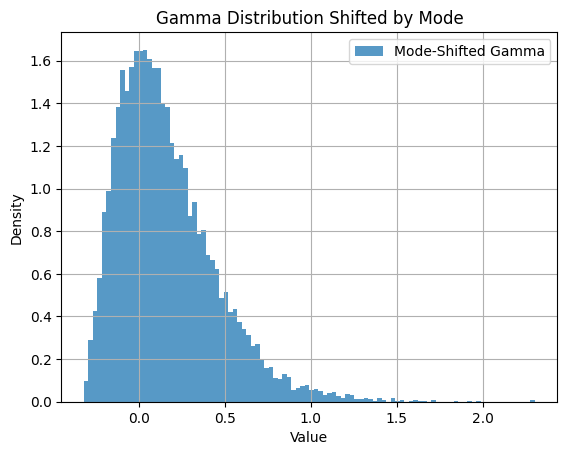

In [4]:
# visualize the Gamma distribution
gamma_noise = GammaNoise(alpha=3.0, beta=6.0)
gamma_noise.visualize()

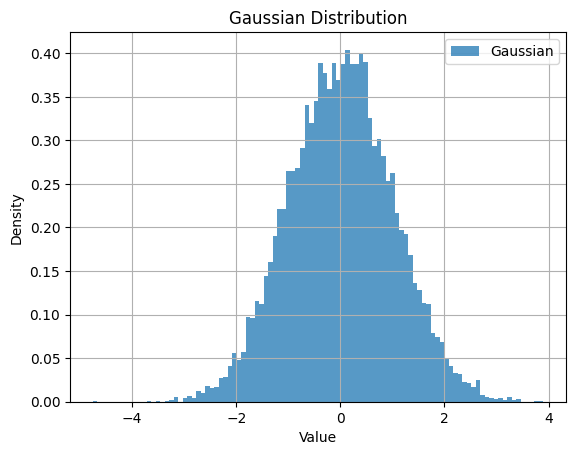

In [5]:
# visualize the Gaussian distribution
gaussian_noise = GaussianNoise(mu=0.0, sigma=1.0)
gaussian_noise.visualize()


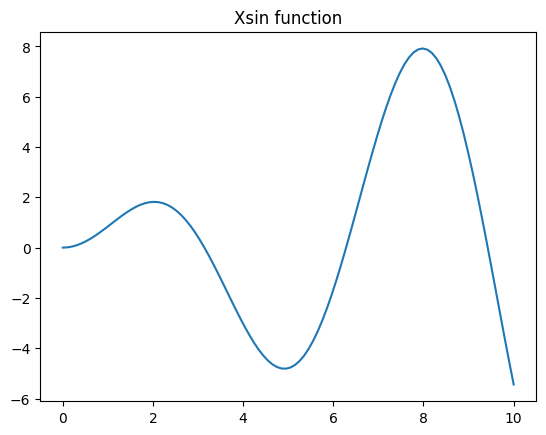

In [6]:
# define the Xsin function  
def Xsin(x):
    return torch.sin(x)*x

# show the function
x = torch.linspace(0, 10, 100)
y = Xsin(x)
plt.plot(x, y)
plt.title('Xsin function')
plt.show()


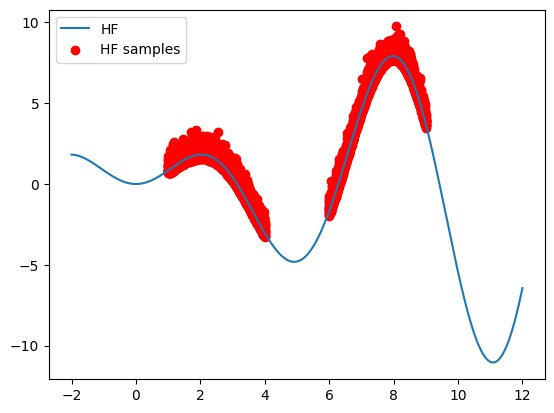

In [7]:
# 
# generate samples (21 HF samples, 201 LF samples)
hf_samples_1 = torch.linspace(1, 4, 5000).reshape(-1, 1)
# add the end points
hf_sample_2 =  torch.linspace(6, 9, 5000).reshape(-1, 1)

hf_samples = torch.cat([hf_samples_1, hf_sample_2], dim=0)

# get the high-fidelity responses
hf_responses = Xsin(hf_samples) + gamma_noise.get_noise(hf_samples)


# generate the test points
test_samples = torch.linspace(-2, 12, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = Xsin(test_samples)

# noise responses
test_hf_responses = Xsin(test_samples) + gamma_noise.get_noise(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
# plot the samples
ax.scatter(hf_samples, hf_responses, color="red", label="HF samples")

plt.legend()
# save the figure
# plt.savefig("sample_plan.png", dpi=300, bbox_inches="tight")
plt.show()

## Define the Bayesian neural network model

In [8]:
# normalize the responses
hf_responses_mean = hf_responses.mean().numpy()
hf_responses_std = hf_responses.std().numpy()
hf_responses_scaled = (hf_responses.clone() -
                       hf_responses_mean) / hf_responses_std

# create the sf_bnn model (suppose we know the noise level)
sigma_scale = float(1.0)

bnn_model = BNNWrapper(
    in_features=1,
    hidden_features=[256, 256],
    out_features=1,
    activation="Tanh",
    lr=0.001,
    sigma=sigma_scale,
)


In [9]:
# train the model
bnn_model.train(
    X=hf_samples,
    Y=hf_responses_scaled,
    num_epochs=27000,
    sample_freq=25,
    burn_in_epochs=2000,

)

/home/yaga/Documents/GitHub/mfbml/src/mfbml/inference/psgld.py:108: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1581.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:     0/27000
nll_loss: 14521.008, prior_loss: 61288.219, total: 75809.227
noise: 1.000
epoch:   100/27000
nll_loss: 11060.895, prior_loss: 61673.328, total: 72734.219
noise: 1.000
epoch:   200/27000
nll_loss: 10556.988, prior_loss: 61955.031, total: 72512.016
noise: 1.000
epoch:   300/27000
nll_loss: 10236.374, prior_loss: 62282.965, total: 72519.336
noise: 1.000
epoch:   400/27000
nll_loss: 10013.775, prior_loss: 62663.023, total: 72676.797
noise: 1.000
epoch:   500/27000
nll_loss: 9962.006, prior_loss: 63108.656, total: 73070.664
noise: 1.000
epoch:   600/27000
nll_loss: 9894.015, prior_loss: 63638.387, total: 73532.398
noise: 1.000
epoch:   700/27000
nll_loss: 9699.592, prior_loss: 64236.500, total: 73936.094
noise: 1.000
epoch:   800/27000
nll_loss: 9715.331, prior_loss: 64909.570, total: 74624.898
noise: 1.000
epoch:   900/27000
nll_loss: 9498.541, prior_loss: 65619.148, total: 75117.688
noise: 1.000
epoch:  1000/27000
nll_loss: 9435.416, prior_loss: 66381.328, total: 75816.

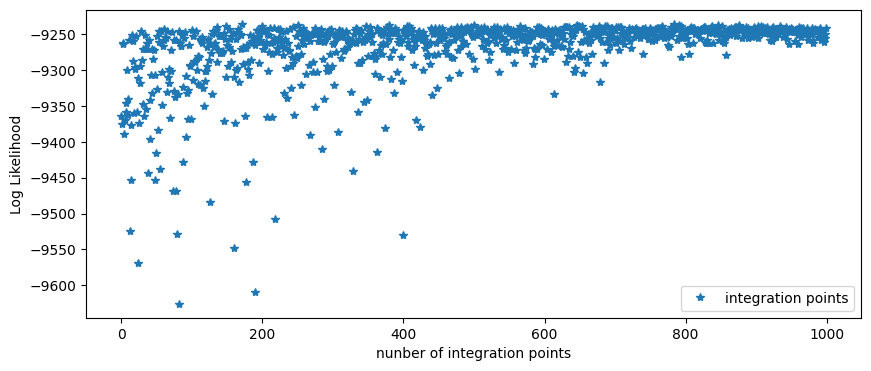

In [10]:
# plot the log likelihood value of the integration of the bayesian neural network
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(bnn_model.log_likelihood, '*', label="integration points")
ax.set_xlabel("nunber of integration points")
ax.set_ylabel("Log Likelihood")
plt.legend()
plt.show()


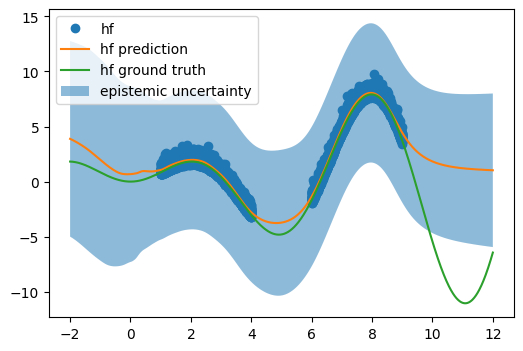

In [11]:
# visualize the posterior of bnn
(bnn_y,
 bnn_epistemic,
 bnn_total_unc,
 bnn_aleatoric) = bnn_model.predict(
    X=test_samples, save_ppd=True)
# scale the prediction
bnn_y = bnn_y * hf_responses_std + hf_responses_mean
bnn_total_unc = bnn_total_unc * hf_responses_std
bnn_epistemic = bnn_epistemic * hf_responses_std
bnn_aleatoric = bnn_aleatoric * hf_responses_std

# plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), bnn_y, label="hf prediction")

ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
# plot the episitmic uncertainty
ax.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_total_unc).reshape(-1),
    (bnn_y + 2 * bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)
# plot aleatoric uncertainty
# ax.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_aleatoric).reshape(-1),
#     (bnn_y + 2 * bnn_aleatoric).reshape(-1),
#     alpha=0.5,
#     label="aleatoric uncertainty",
# )
plt.legend()
plt.show()

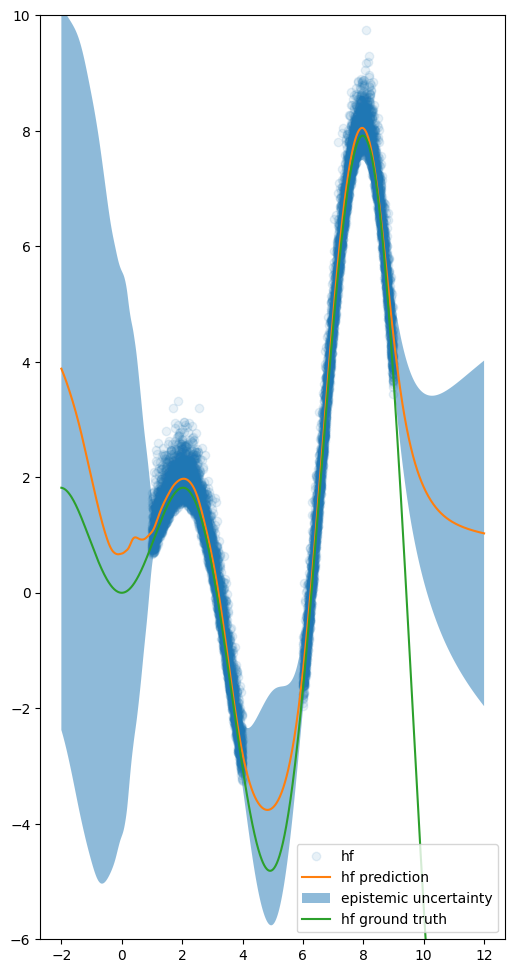

In [21]:
# plot the ppd of the bnn
fig, ax = plt.subplots(figsize=(6, 12))
ax.plot(hf_samples, hf_responses, "o", label="hf", alpha=0.1)
ax.plot(test_samples, bnn_y, label="hf prediction")
# ax.fill_between(
#     test_samples.flatten().numpy(),
#     (bnn_y - 2 * bnn_total_unc).reshape(-1),
#     (bnn_y + 2 * bnn_total_unc).reshape(-1),
#     alpha=0.5,
#     label="total uncertainty",
# )
# epistemic uncertainty
ax.fill_between(
    test_samples.flatten().numpy(),
    (bnn_y - 2 * bnn_epistemic).reshape(-1),
    (bnn_y + 2 * bnn_epistemic).reshape(-1),
    alpha=0.5,
    label="epistemic uncertainty",
)

ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.set_ylim(-6, 10)
plt.legend()
plt.show()


tensor([8.0800])


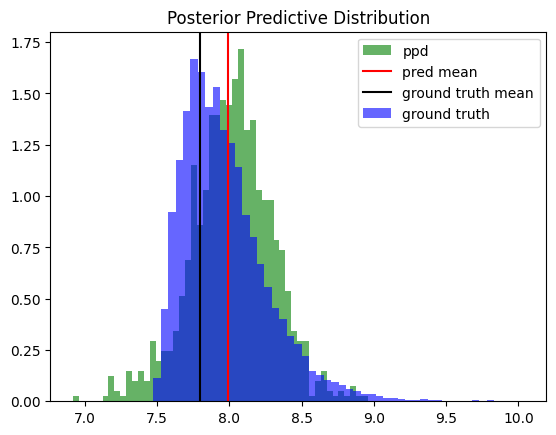

In [27]:
loc_index = 720 
# print the x value
print(test_samples[loc_index])

# histogram of the posterior predictive distribution
raw = np.zeros((len(bnn_model.responses), 1))
for ii in range(len(bnn_model.responses)):
    raw[ii] = bnn_model.responses[ii][loc_index, :]*hf_responses_std + hf_responses_mean


fig, ax = plt.subplots()
ax.hist(raw, 
        bins=50, 
        density=True,
        alpha=0.6, color="g", label="ppd")
# plot the mean of this point
ax.axvline(x=bnn_y[loc_index], color="red", label="pred mean")
ax.axvline(x=test_hf_responses[loc_index], color="black", label="ground truth mean")
# generate the ground truth distribution using gaussian distribution
ground_truth = test_hf_responses[loc_index].numpy()
# histogram of the ground truth
# sample from the noise 
gamma_dist = torch.distributions.Gamma(gamma_noise.alpha, gamma_noise.beta)
gamma_samples = gamma_dist.sample((10000,))

shifted_samples = gamma_samples - gamma_noise.mode + ground_truth
ax.hist(shifted_samples.numpy(), bins=50, density=True, alpha=0.6, color="b", label="ground truth")

# sample from the gaussian noise
# normal_dist = torch.distributions.Normal(gaussian_noise.mu, gaussian_noise.sigma)
# normal_samples = normal_dist.sample((10000,)) + ground_truth
# ax.hist(normal_samples.numpy(),
#         bins=50,
#         density=True,
#         alpha=0.6,
#         color="b", label="ground truth")

# # plot the total uncertainty using the gaussian distribution
# std = bnn_aleatoric * hf_responses_std
# x = np.linspace(bnn_y[loc_index] - 5 * std, bnn_y[loc_index] + 5 * std, 100)
# y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(
#     -0.5 * ((x - bnn_y[loc_index]) / std) ** 2
# )
# ax.plot(x, y, label="aleatoric uncertainty distribution")
# # # plot the total uncertainty using the gaussian distribution
# std = bnn_total_unc[loc_index]
# x = np.linspace(bnn_y[loc_index] - 5 * std, bnn_y[loc_index] + 5 * std, 100)
# y = (1 / (std * np.sqrt(2 * np.pi))) * np.exp(
#     -0.5 * ((x - bnn_y[loc_index]) / std) ** 2
# )
# ax.plot(x, y, label="total uncertainty distribution")

# # ax.plot(x, y, label=" aleatoric uncertainty distribution")

plt.legend()

ax.set_title("Posterior Predictive Distribution")
plt.savefig("ppd_10000_sigma_100_Gamma.png", dpi=300, bbox_inches="tight")
plt.show()